In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk

# Fiddle with figure settings here:
plt.rcParams['figure.figsize'] = (10,8)
plt.rcParams['font.size'] = 14
plt.rcParams['image.cmap'] = 'plasma'
plt.rcParams['axes.linewidth'] = 2
# Set the default colour cycle (in case someone changes it...)
from cycler import cycler
cols = plt.get_cmap('tab10').colors
plt.rcParams['axes.prop_cycle'] = cycler(color=cols)

In [2]:
search = lk.search_lightcurve('U Gru', cadence=120)
lc = search[-1].download().remove_nans().remove_outliers().normalize()

/home/colej/software/miniconda3/envs/nominal/lib/python3.9/site-packages/lightkurve/lightcurve.py:1131: LightkurveWarning: The light curve appears to be zero-centered (median=7.51e+03 ppm +/- 1.53e+05 ppm); `normalize()` will divide the light curve by a value close to zero, which is probably not what you want.
  warnings.warn(


<IPython.core.display.Javascript object>


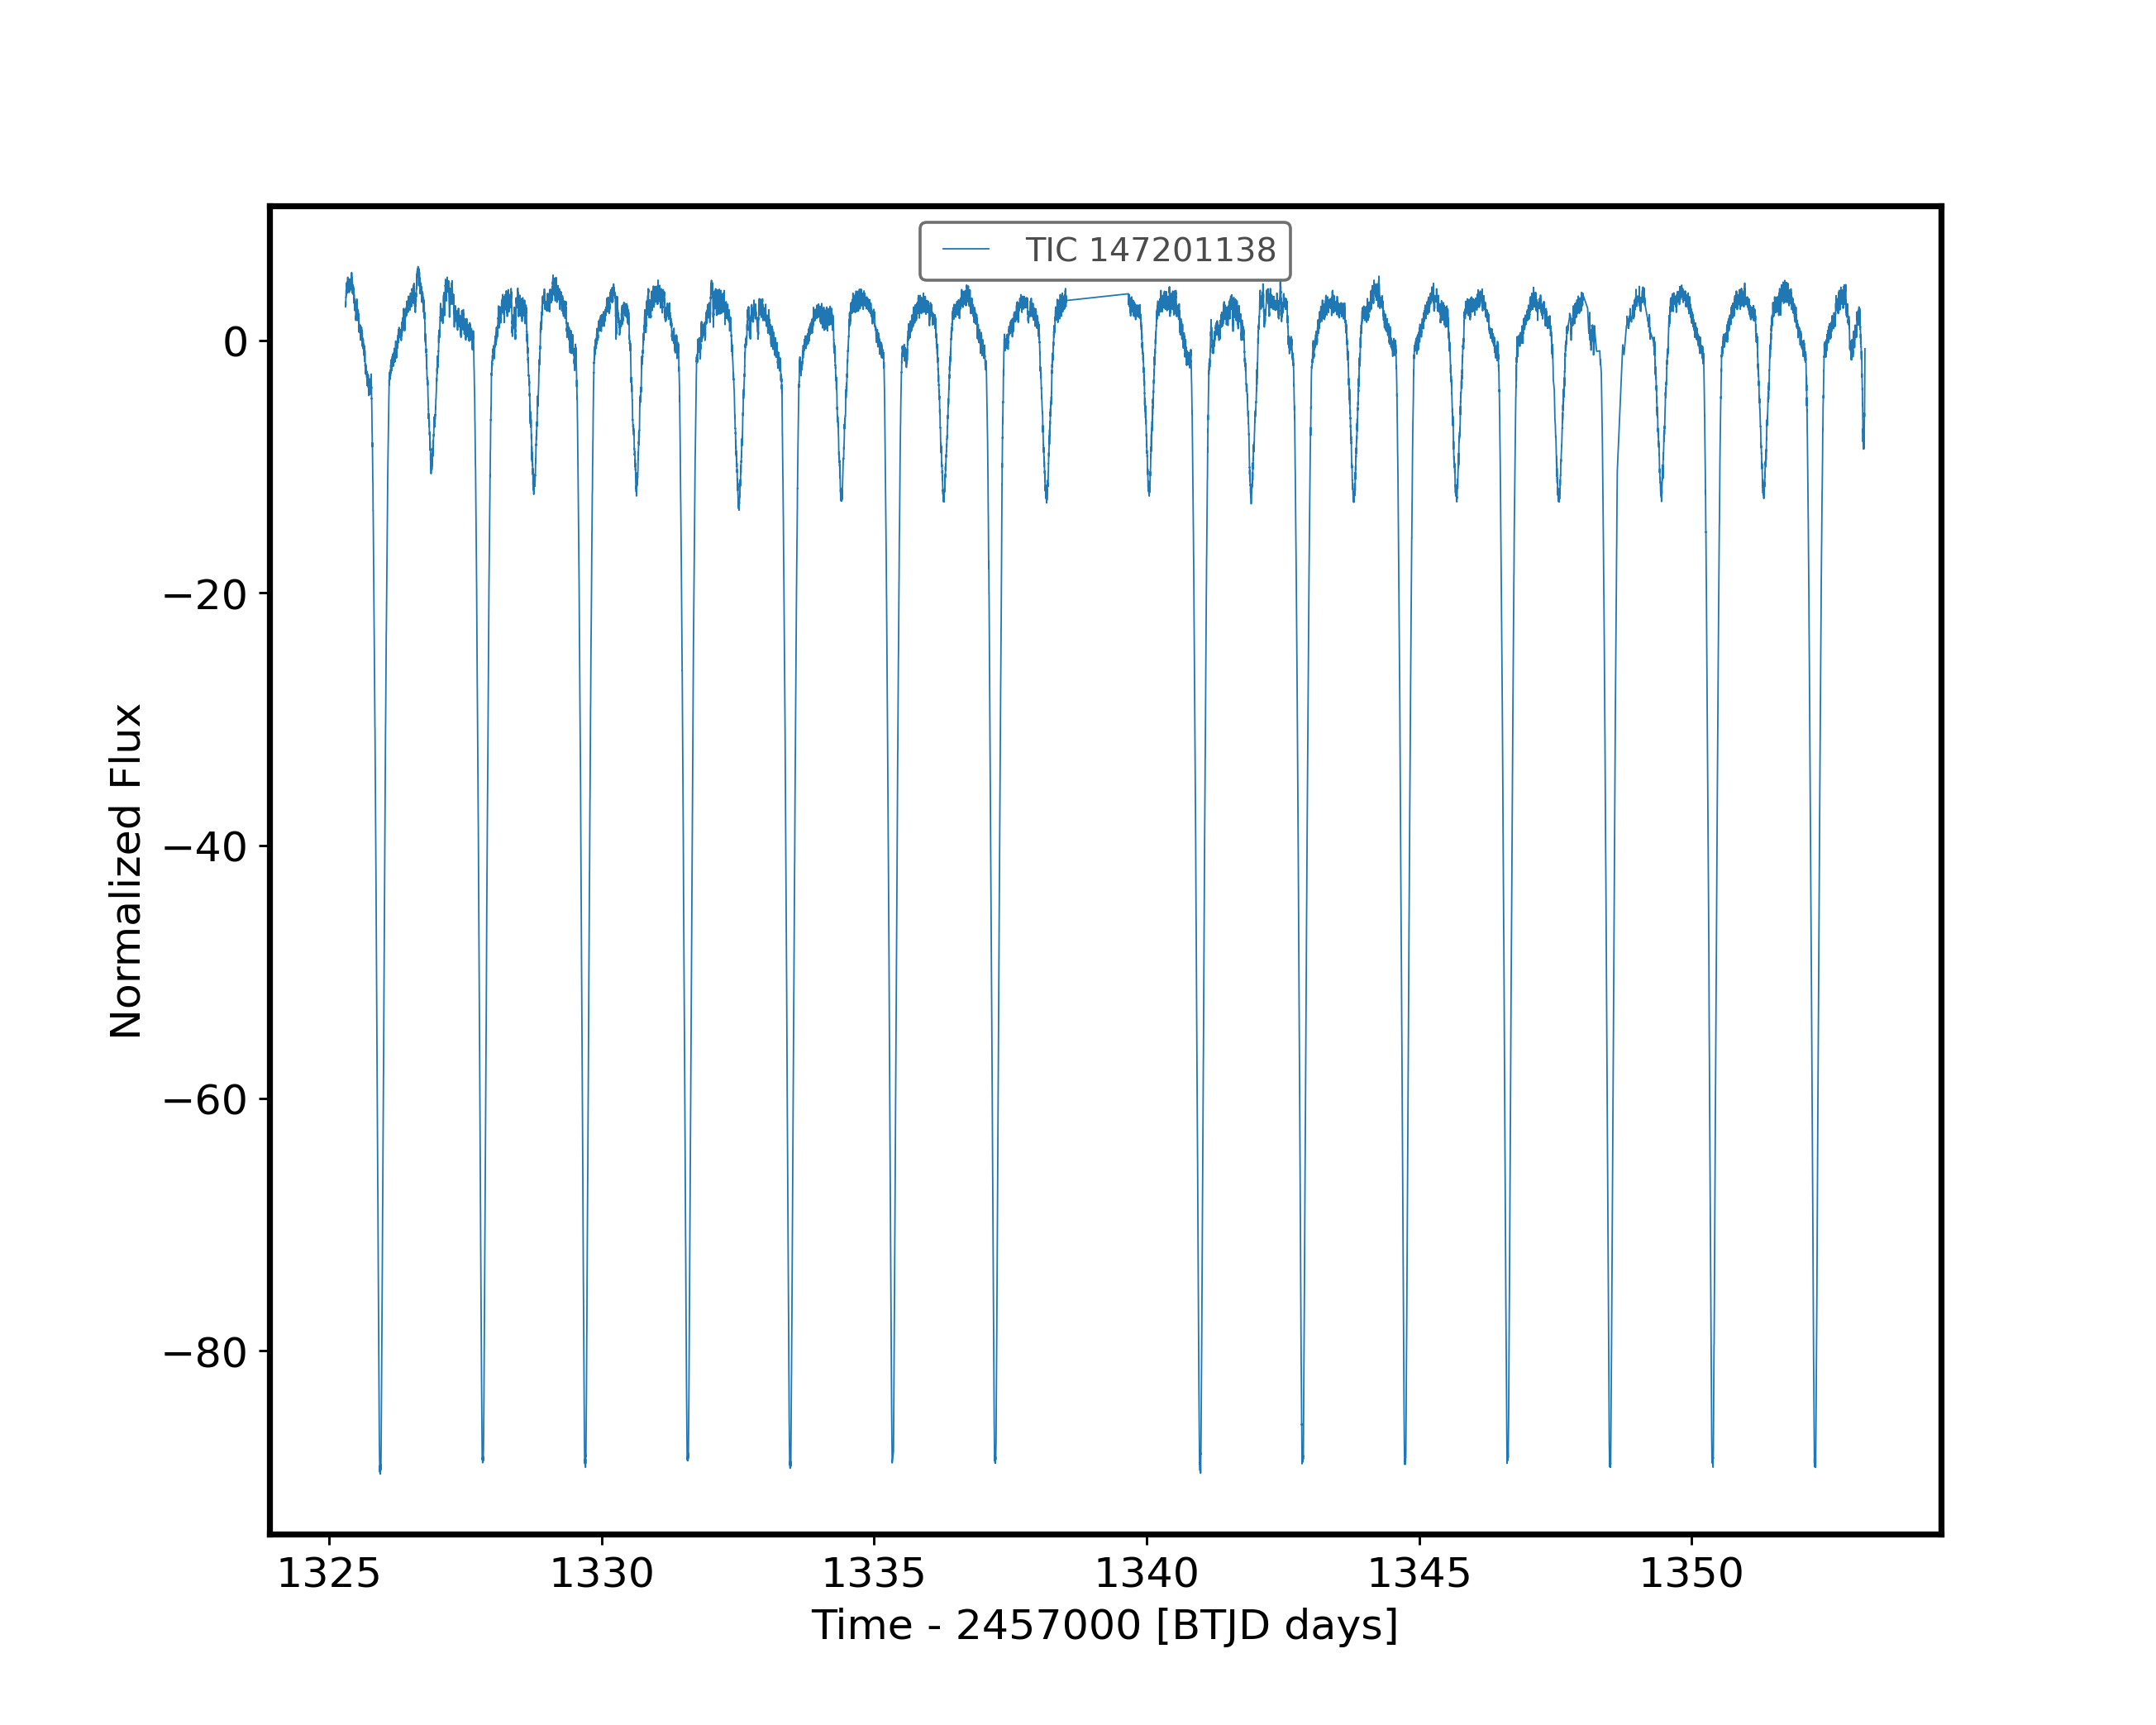

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

In [3]:
fig_lc, ax_lc = plt.subplots(num=1)
lc.plot(ax=ax_lc)

<IPython.core.display.Javascript object>


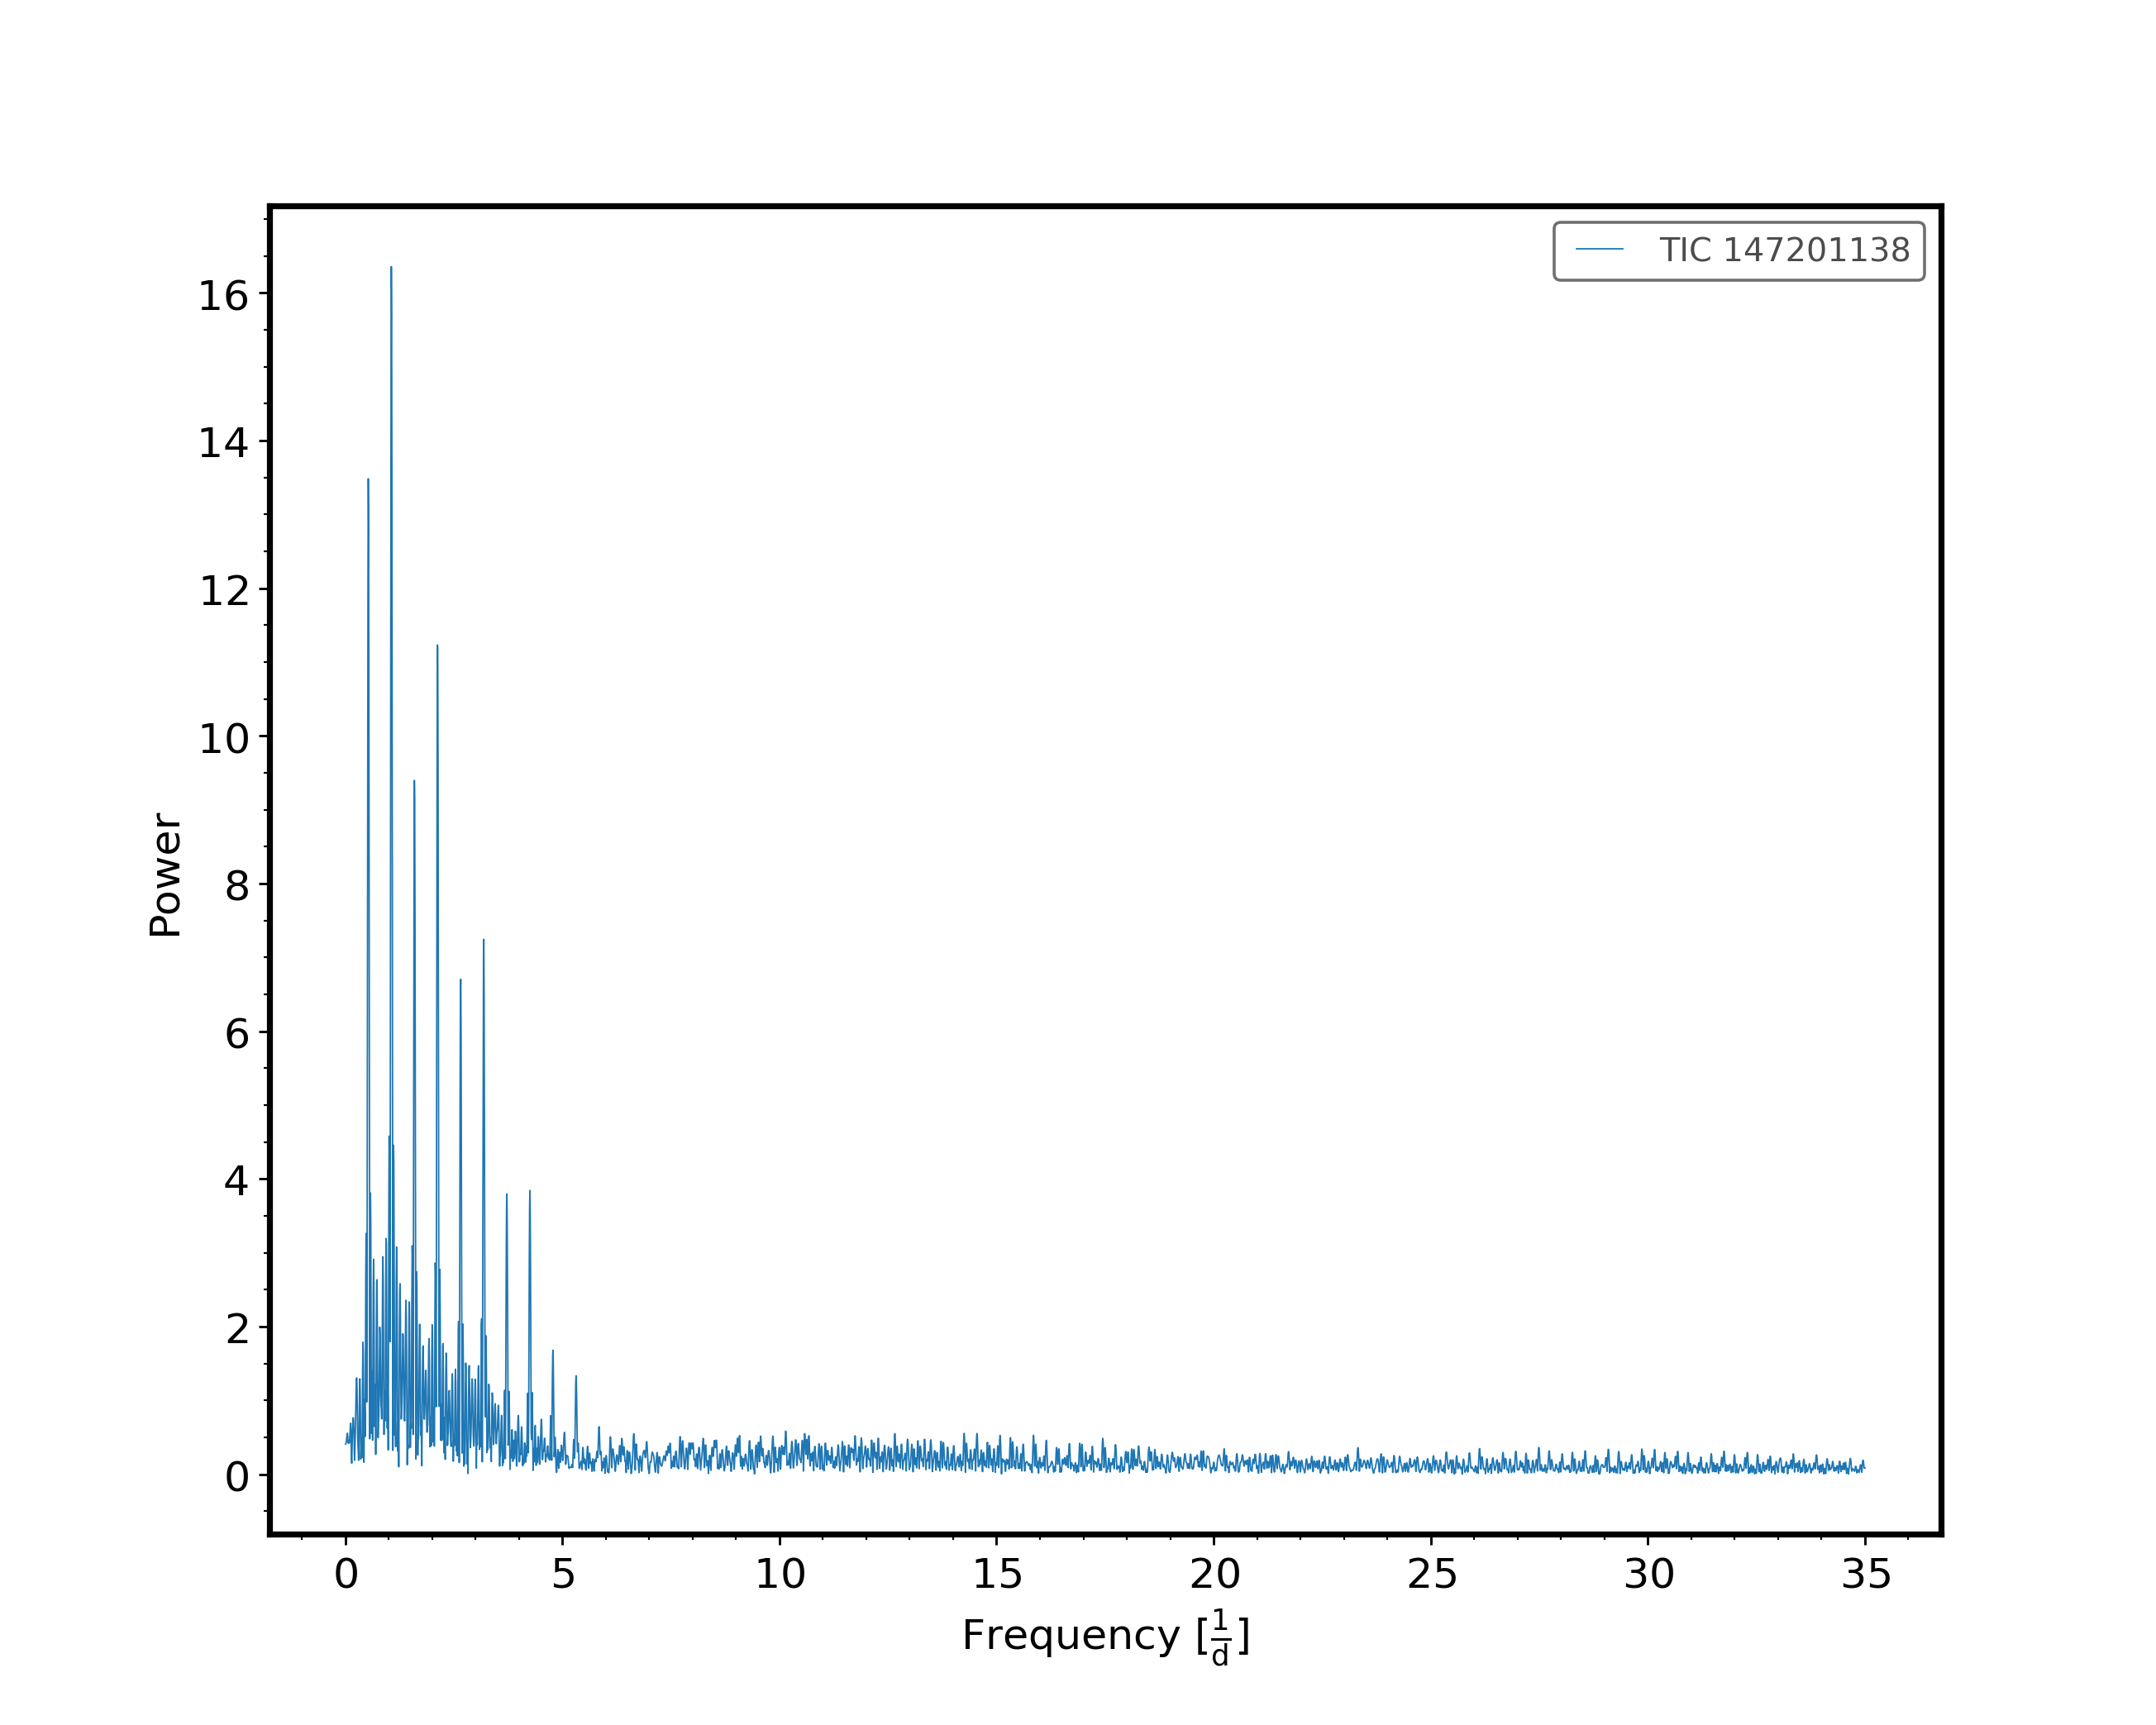

In [4]:
ls = lc.to_periodogram(maximum_frequency=35)
fig, ax = plt.subplots(num=2)
ls.plot(ax=ax)
plt.show()

In [5]:
period = 1.8805
time = np.array(lc.time.value)
flux = np.array(lc.flux.value)
ferr = np.array(lc.flux_err.value)

Setup variables for the PCA

In [6]:
N = len(time)
L = len(time[time < time[0]+period])# window length
L += int(0.1*L) * 2
print('Window length: {:d} points'.format(L))
K = N - L + 1 # number of columns in the trajectory matrix
X = np.column_stack([flux[i:i+L] for i in range(0,K)]) # Trajectory matrix

d = 25


Window length: 1601 points


In [7]:
def pca_decomposition(A):
    M = np.mean(A, axis=0)
    C = A - M
    print(A.shape, M.shape, C.shape)
    V = np.cov(C)
    values, vectors = np.linalg.eig(V)
    
    return values, vectors

def X_to_TS(X_i):
    """Averages the anti-diagonals of the given elementary matrix, X_i, and returns a time series."""
    # Reverse the column ordering of X_i
    X_rev = X_i[::-1]
    # Full credit to Mark Tolonen at https://stackoverflow.com/a/6313414 for this one:
    return np.array([X_rev.diagonal(i).mean() for i in range(-X_i.shape[0]+1, X_i.shape[1])])

In [8]:
values, vectors = pca_decomposition(X)

(1601, 16503) (16503,) (1601, 16503)


In [9]:
X_elem_pca = np.array([np.dot(np.dot(np.expand_dims(vectors[:,i], axis=1), np.expand_dims(vectors[:,i].T, axis=0)), X) for i in range(0,d)])

<IPython.core.display.Javascript object>


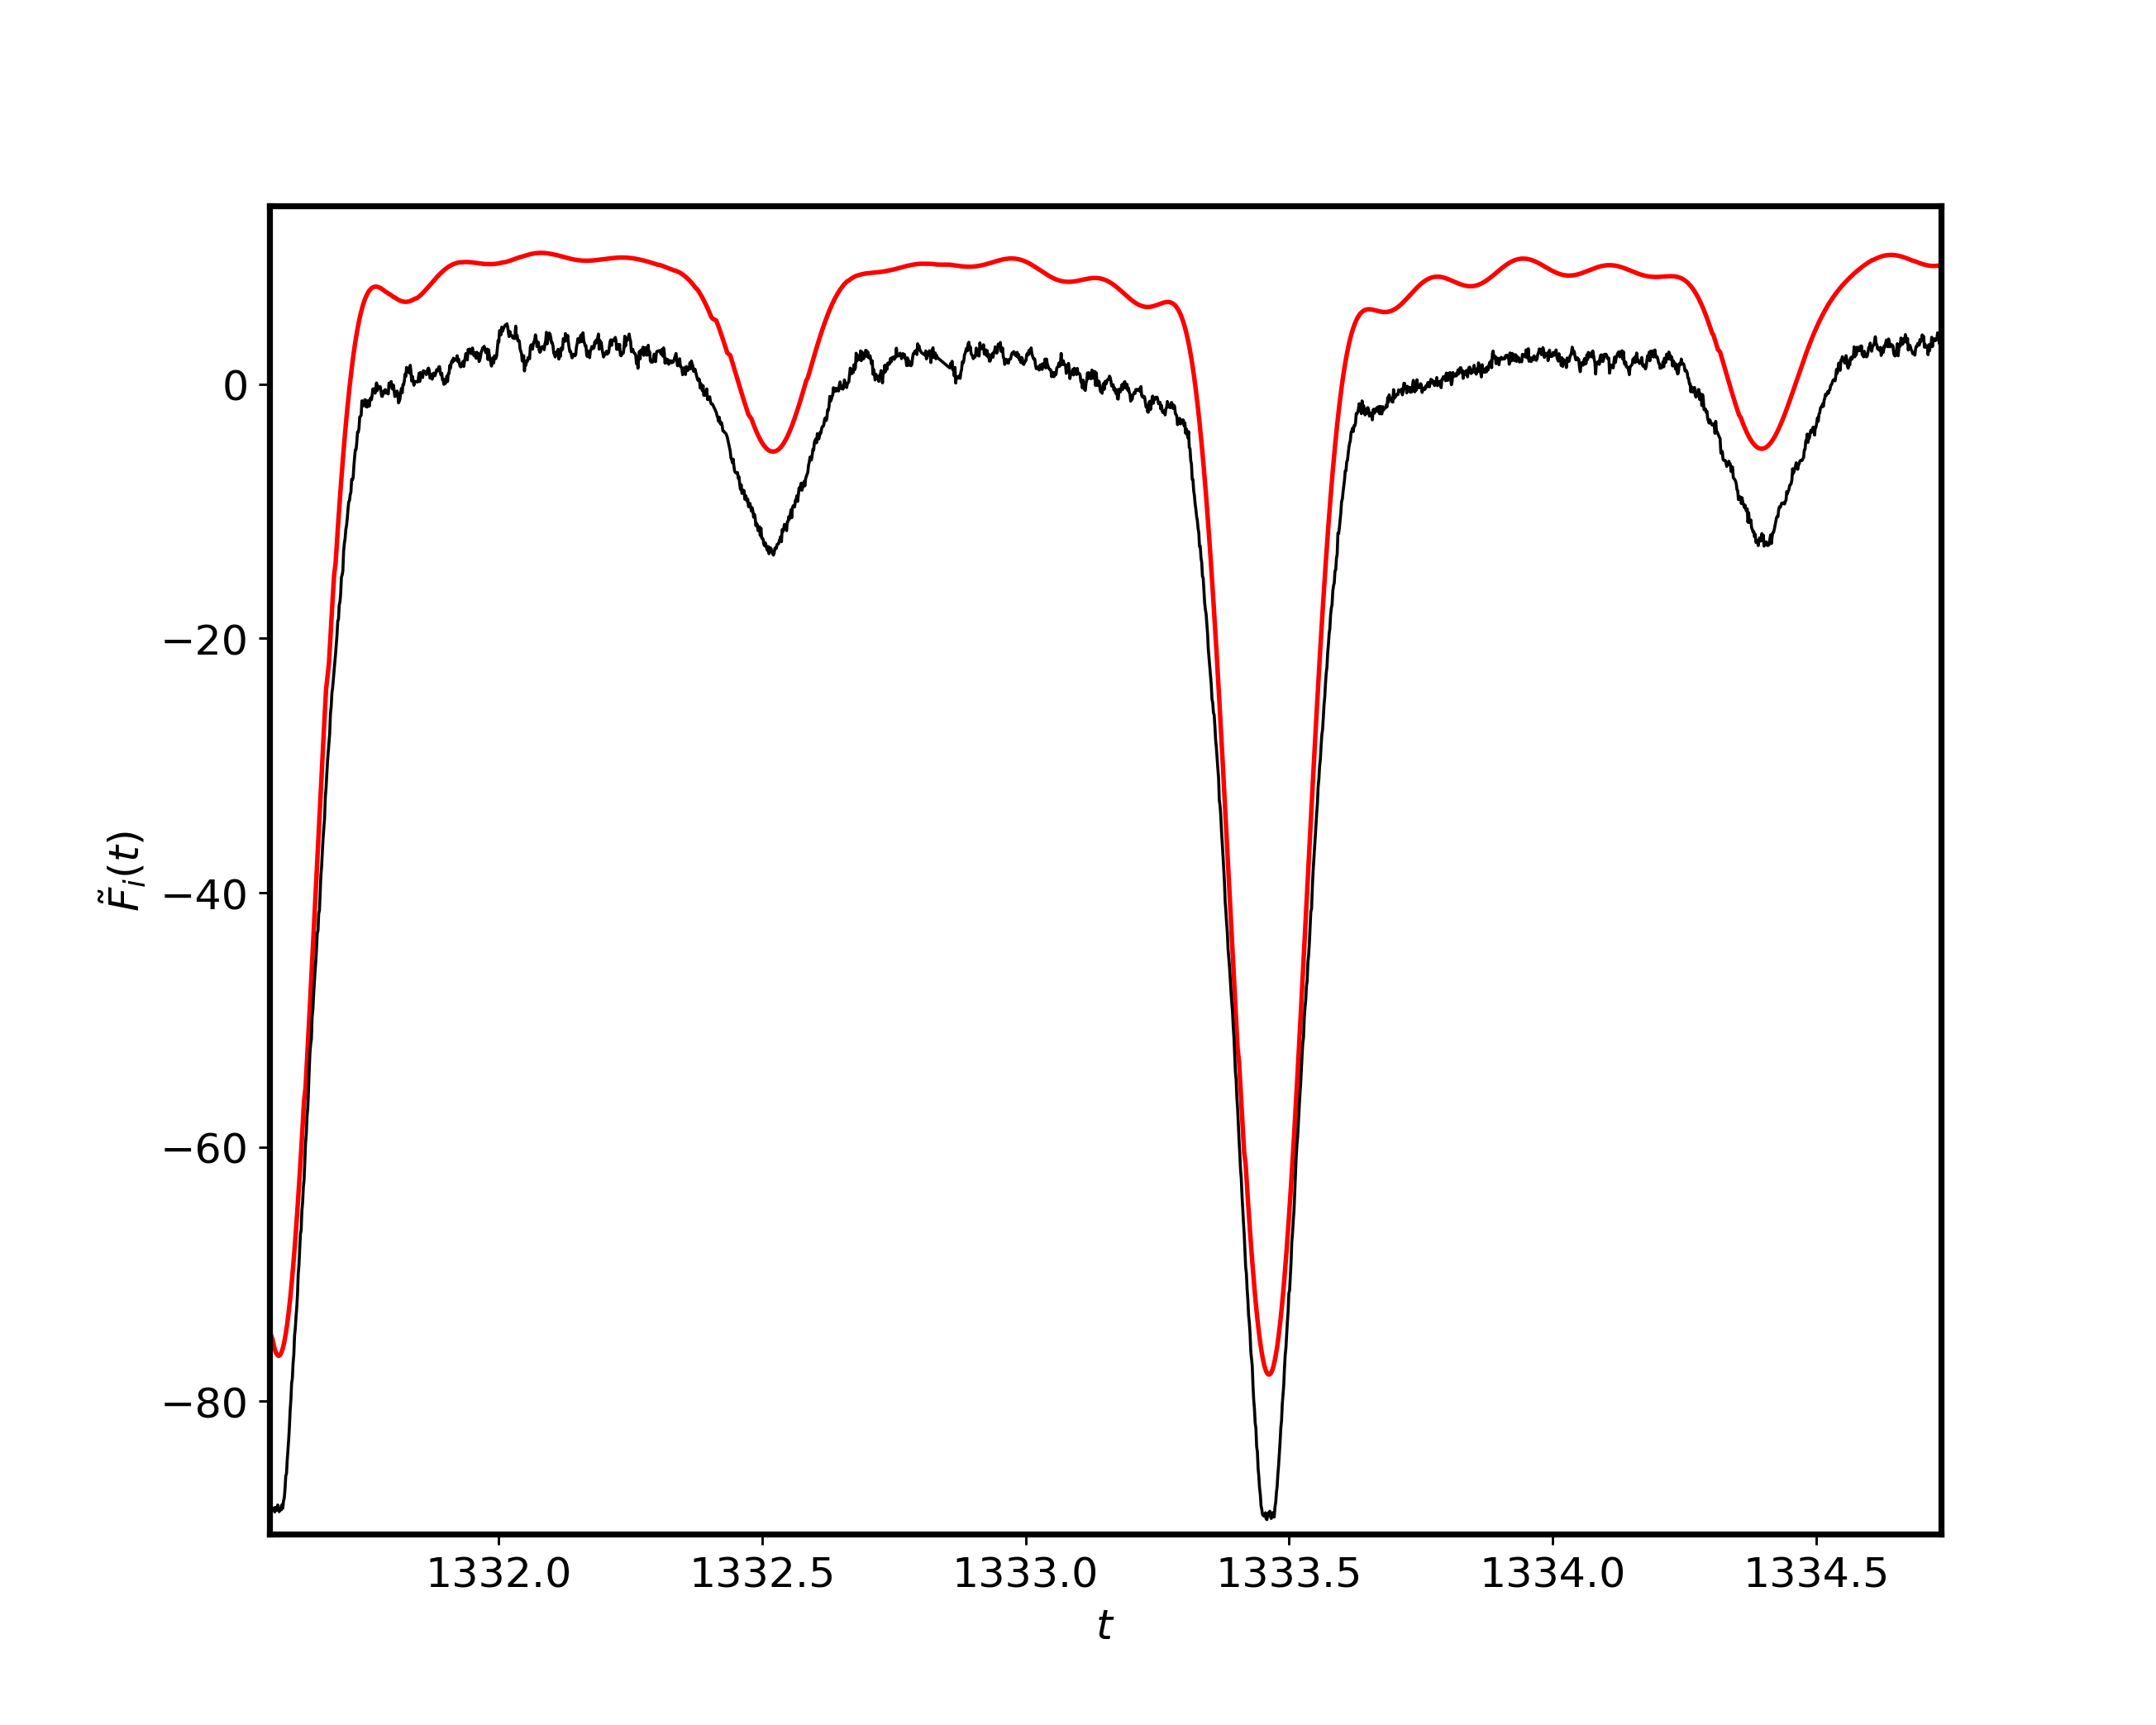

In [12]:
n = min(70,d) # In case of noiseless time series with d < 12.

# Fiddle with colour cycle - need more colours!
fig,ax = plt.subplots(1,1,num=5)
color_cycle = cycler(color=plt.get_cmap('tab20').colors)
ax.set_prop_cycle(color_cycle)

# Convert elementary matrices straight to a time series - no need to construct any Hankel matrices.
# for i in range(n):
#     F_i = X_to_TS(X_elem_pca[i])
#     ax.plot(time, F_i, lw=2)

reconstructed = X_to_TS(X_elem_pca[:].sum(axis=0))
ax.plot(time, reconstructed, 'r-')
ax.plot(time, flux, 'k-', alpha=1, lw=1)
ax.set_xlabel("$t$")
ax.set_ylabel(r"$\tilde{F}_i(t)$")
legend = [r"$\tilde{F}_{%s}$" %i for i in range(n)] + ["$F$"]
# fig.set_title("The First 12 Components of the Toy Time Series")
fig.legend(legend, loc=(1.05,0.1))
plt.show()

In [14]:
from pythia.timeseries.lombscargle import LS_periodogram

nu, amp = LS_periodogram(time, resid, max=35)
print(resid, amp)

[-7.00687823 -6.89399503 -6.56823891 ...  0.61364893  1.55033047
  3.3021835 ] [0.10291146 0.10680054 0.11068261 ... 0.00688104 0.00417799 0.00160291]


<IPython.core.display.Javascript object>


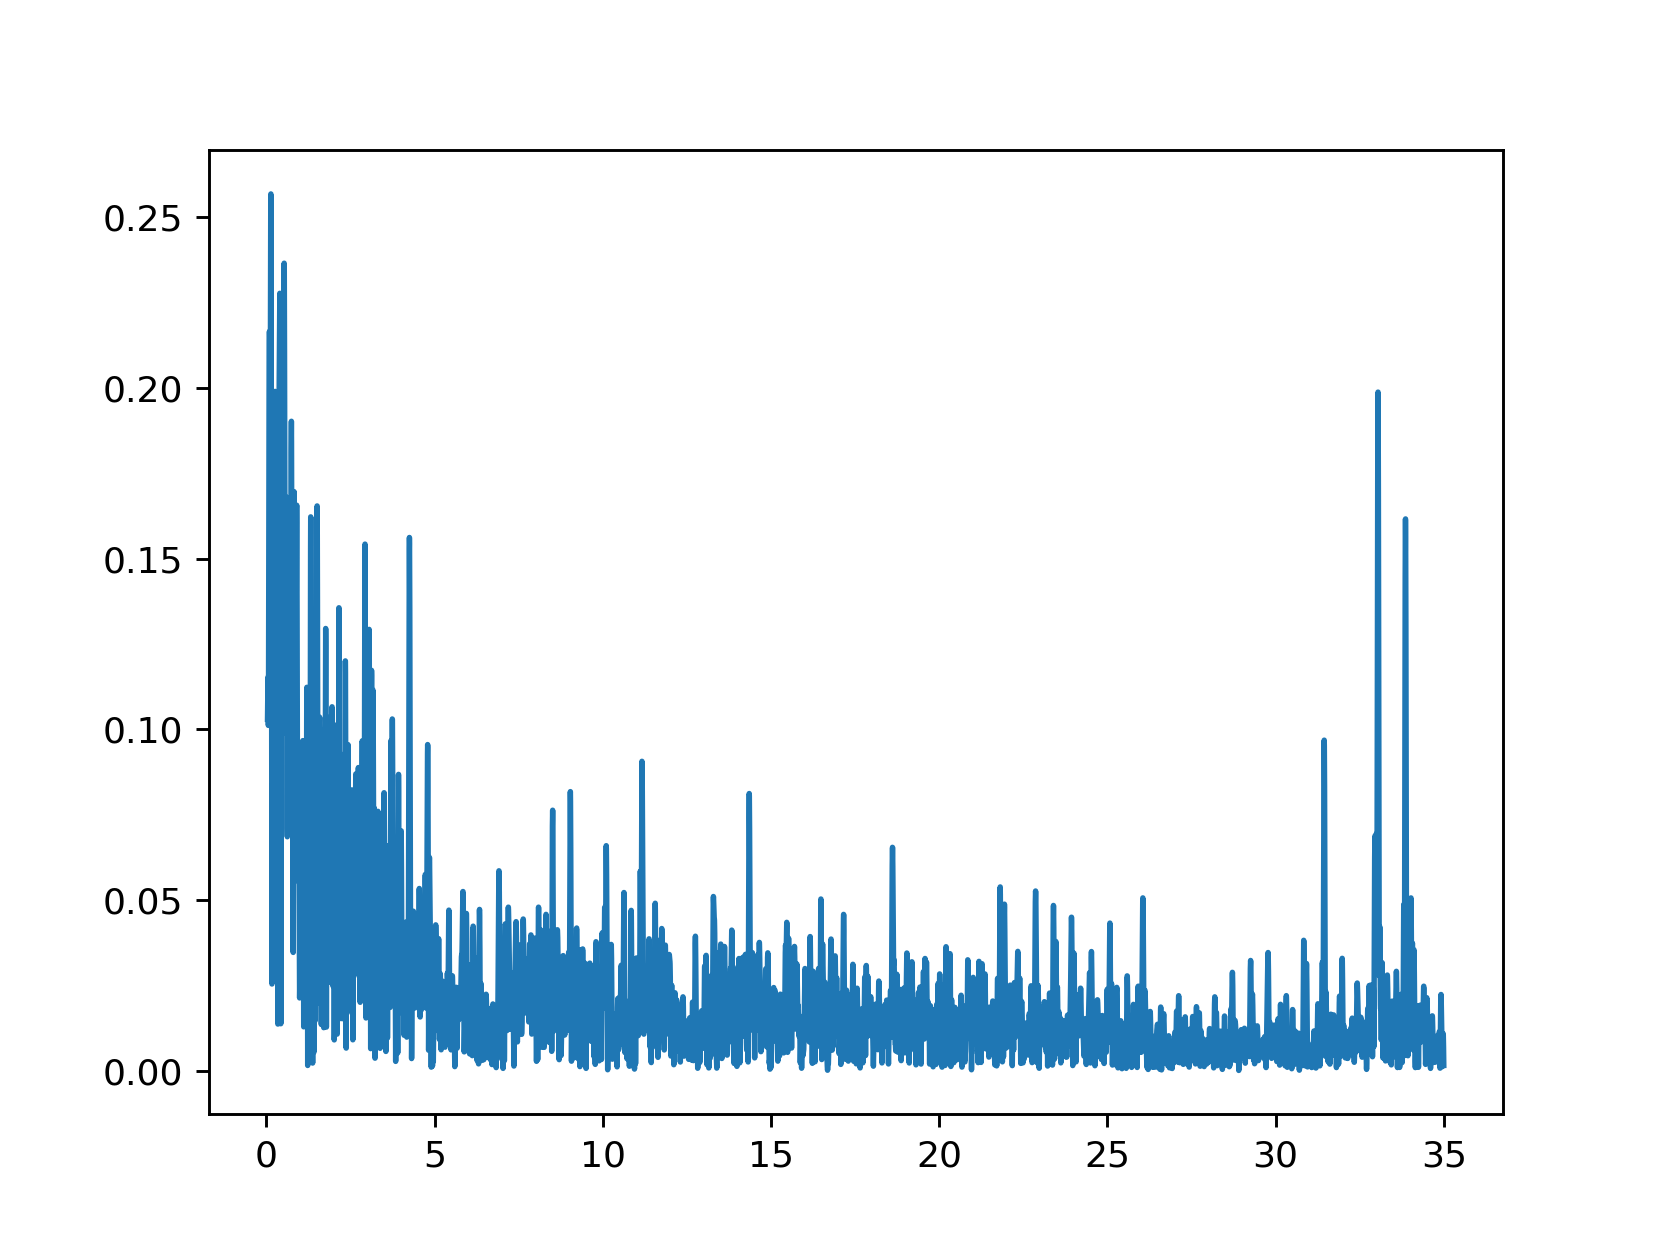

In [15]:
fig_, ax_ = plt.subplots(num=7)
ax_.plot(nu, amp)